In [649]:
import lightkurve as lk
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.stats import sigma_clipped_stats, sigma_clip
import numpy as np
from scipy.signal import medfilt
from astropy.convolution import convolve, Box1DKernel, Box2DKernel, Gaussian2DKernel
from astropy.stats import LombScargle
plt.style.use(lk.MPLSTYLE)
from tqdm import tqdm

import starry
from starry.kepler import Primary, Secondary, System

#period, t0 = 1.6696334816740839, 1363.1389770507812
period, t0 = 1.669530708135147, 0.7945727531770768

In [845]:
from numpy import ma
from matplotlib import cbook
from matplotlib.colors import Normalize

class MidPointNorm(Normalize):    
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")       
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = ma.getmask(result)
                result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint            
            resdat[resdat>0] /= abs(vmax - midpoint)            
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = ma.array(resdat, mask=result.mask, copy=False)                

        if is_scalar:
            result = result[0]            
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if cbook.iterable(value):
            val = ma.asarray(value)
            val = 2 * (val-0.5)  
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0: 
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint

In [2]:
def poly_detrend(lc):
    ''' Detrend a light curve with a simple third order polynomial
    '''
    clc = lc.copy()
    split = np.where(np.diff(clc.time) > 0.5)[0][0]+1
    f = clc[:split].remove_outliers(3)
    corr = lk.LightCurve(clc[:split].time, np.polyval(np.polyfit(f.time, f.flux, 3), clc[:split].time))

    f = clc[split:].remove_outliers(3)
    corr = corr.append(lk.LightCurve(clc[split:].time, np.polyval(np.polyfit(f.time, f.flux, 3), clc[split:].time)))
    return corr

In [4]:
tpf = lk.TessTargetPixelFile('../data/zet-phe.fits')
tpf = tpf[~(np.nansum(tpf.flux, axis=(1,2)) == 0)]

In [15]:
flux = tpf.flux
thumb = np.nanpercentile(flux, 95, axis=0)
mask = thumb > np.nanpercentile(thumb[:, 62:], 10)

# Make sure to throw away the edge
mask[:, :62] = True
mask[~np.isfinite(thumb)] = True

# Build a background estimate using astropy sigma clipping
mean, med, sigma = np.asarray([sigma_clipped_stats(f, mask=mask) for f in flux]).T

# Remove the median background
flux = tpf.flux - np.atleast_3d(med).transpose([1, 2, 0])
flux = flux[:, 3:, 62:-62]

# HAVE to add the minimum back in, otherwise some flux values are negative!
flux -= np.min(flux)

flux_err = tpf.flux_err
flux_err = flux_err[:, 3:, 62:-62]
aper = tpf.pipeline_mask[3:, 62:-62]

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [678]:
x_fold = (tpf.time - t0 - period/2) / period % 1 - 0.5

In [625]:
saturated = np.nanmax(flux, axis=0) > 100000
for idx, s in enumerate(saturated.T):
    saturated[:, idx] = (convolve(s, Box1DKernel(5)) > 1e-5)

saturated |= np.nanmax(flux, axis=0) > 50000
for idx, s in enumerate(saturated.T):
    saturated[:, idx] = (convolve(s, Box1DKernel(10)) > 1e-5)

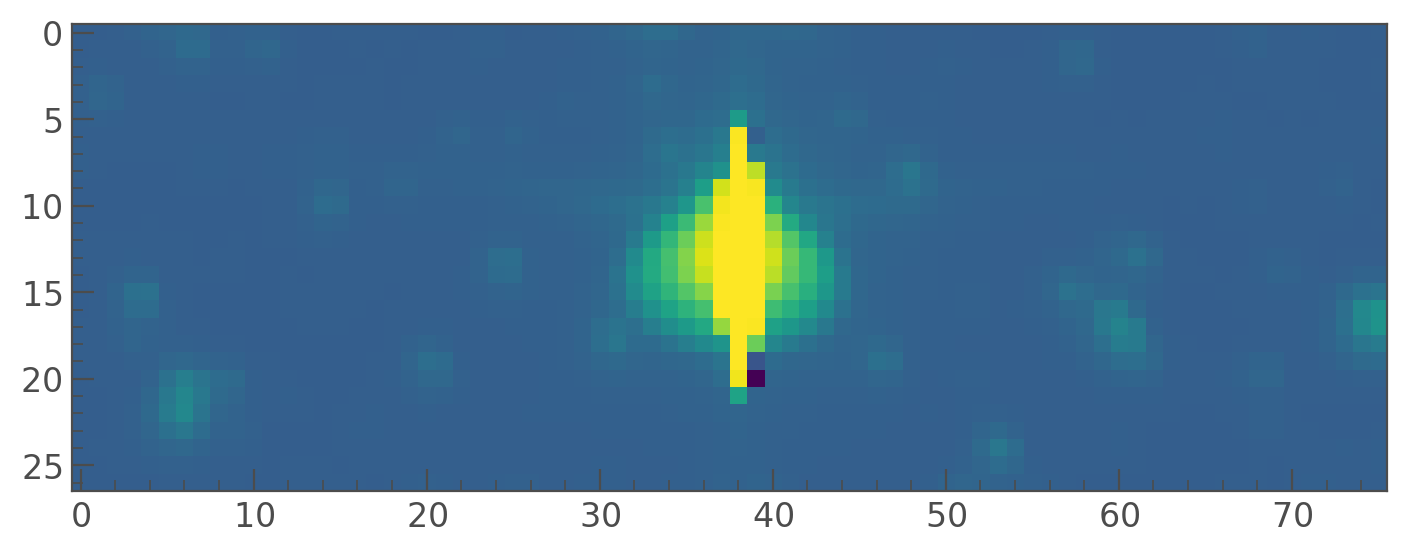

In [628]:
plt.imshow(np.log10(flux[0]))

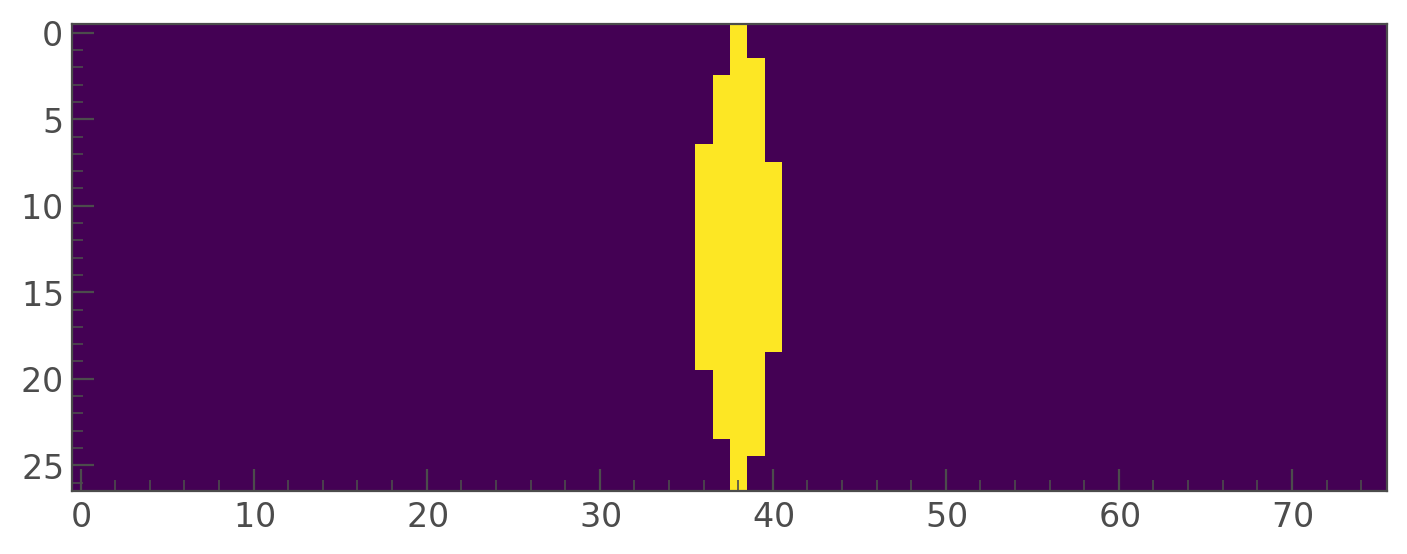

In [626]:
plt.imshow(saturated)

In [703]:
all_aper = np.ones(flux.shape[1:], bool)

In [704]:
true = lk.LightCurve(tpf.time, np.nansum(flux[:, all_aper], axis=(1))).normalize()

In [705]:
#p = true.to_periodogram('bls', minimum_period=1.64, maximum_period=1.69, frequency_factor=0.1, duration=0.15)
#p.plot()

In [706]:
#p.period_at_max_power.value, p.transit_time_at_max_power

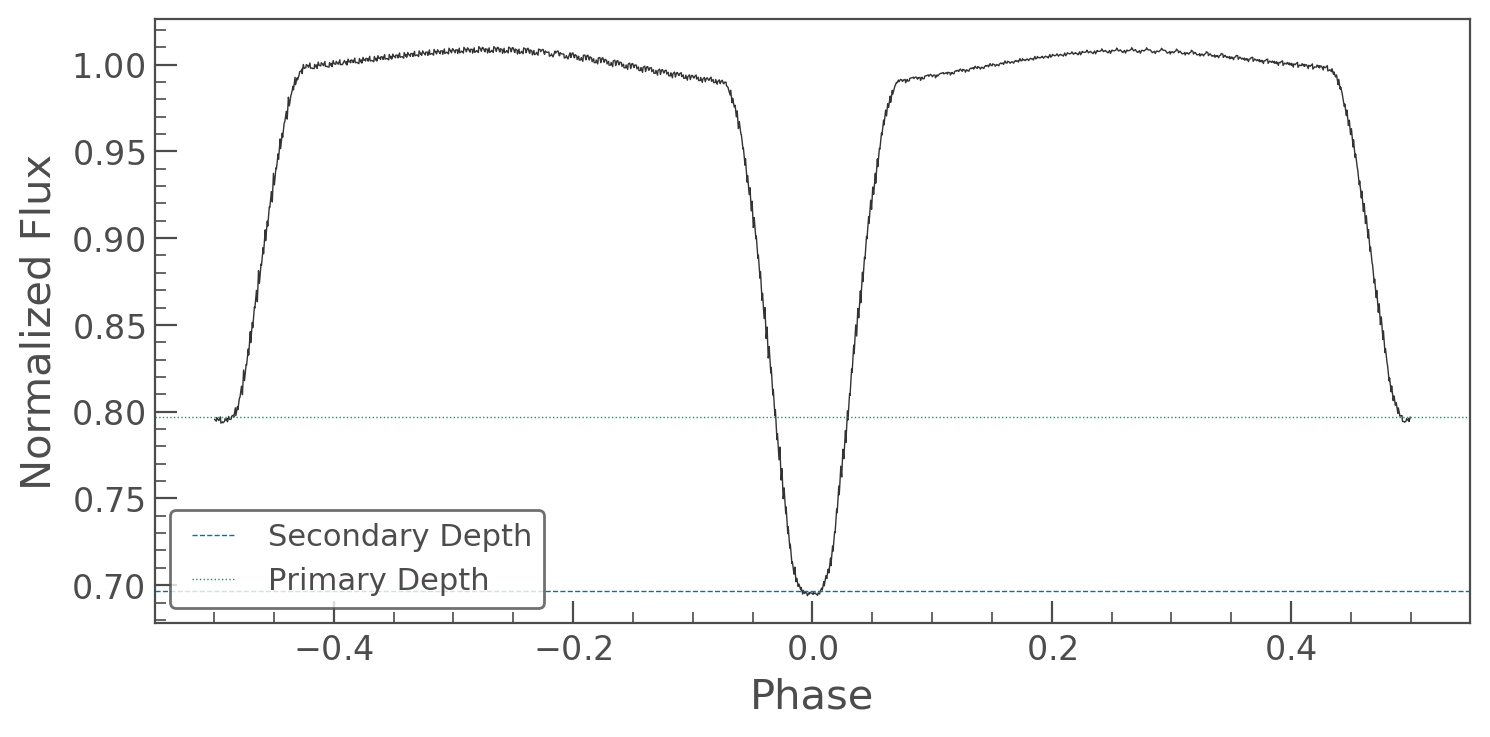

In [707]:
true_primary_depth = np.nanmedian(true.flux[np.abs(x_fold) < 0.015])
true_secondary_depth = np.nanmedian(true.flux[np.abs(x_fold) > 0.48])

ax = true.fold(period, t0).plot()
ax.axhline(true_primary_depth, color='C1', ls='--', label='Secondary Depth')
ax.axhline(true_secondary_depth, color='C2', ls=':', label='Primary Depth')
ax.legend()

In [956]:
c_flux = np.zeros(flux.shape)
primary_depth = np.zeros(flux.shape[1:])
secondary_depth = np.zeros(flux.shape[1:])

primary_depth_err = np.zeros(flux.shape[1:])
secondary_depth_err = np.zeros(flux.shape[1:])

std = np.zeros(flux.shape[1:])

for jdx in tqdm(range(flux.shape[2])):
    for idx in range(flux.shape[1]):
        # BUILD a lk object
        l1 = lk.LightCurve(tpf.time, flux[:, idx, jdx], flux_err=flux_err[:, idx, jdx])
        # Detrend long term
        l1 /= poly_detrend(l1).flux
        primary_depth[idx, jdx] = np.nanmedian(l1.flux[np.abs(x_fold) < 0.015])
        primary_depth_err[idx, jdx] = np.nanstd(l1.flux[np.abs(x_fold) < 0.015])

        #d = (1 - primary_depth[idx, jdx])/(1 - true_primary_depth)
        #l1 = (l1* (1/d) - (1/d) + 1)
        secondary_depth[idx, jdx] = np.nanmedian(l1.flux[np.abs(x_fold) > 0.48])
        secondary_depth_err[idx, jdx] = np.nanstd(l1.flux[np.abs(x_fold) > 0.48])
        
        std[idx, jdx] = (l1/true.flux)[(np.abs(x_fold) > 0.1) & (np.abs(x_fold) < 0.4)].flux.std()
        c_flux[:, idx, jdx] = l1.flux
        
        
#c_flux[:, saturated] = np.nan
primary_depth[saturated] = np.nan
secondary_depth[saturated] = np.nan
#primary_depth_err[saturated] = np.nan
#secondary_depth_err[saturated] = np.nan
#std[saturated] = np.nan

100%|██████████| 76/76 [00:06<00:00, 12.58it/s]


In [957]:
#plt.imshow(std#, vmax=0.5)
#plt.colorbar()

In [1000]:
aper = (primary_depth < 0.95) & ~saturated
#c_flux[:, ~aper] = np.nan
#primary_depth[~aper] = np.nan
#secondary_depth[~aper] = np.nan
#primary_depth_err[~aper] = np.nan
#secondary_depth_err[~aper] = np.nan

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


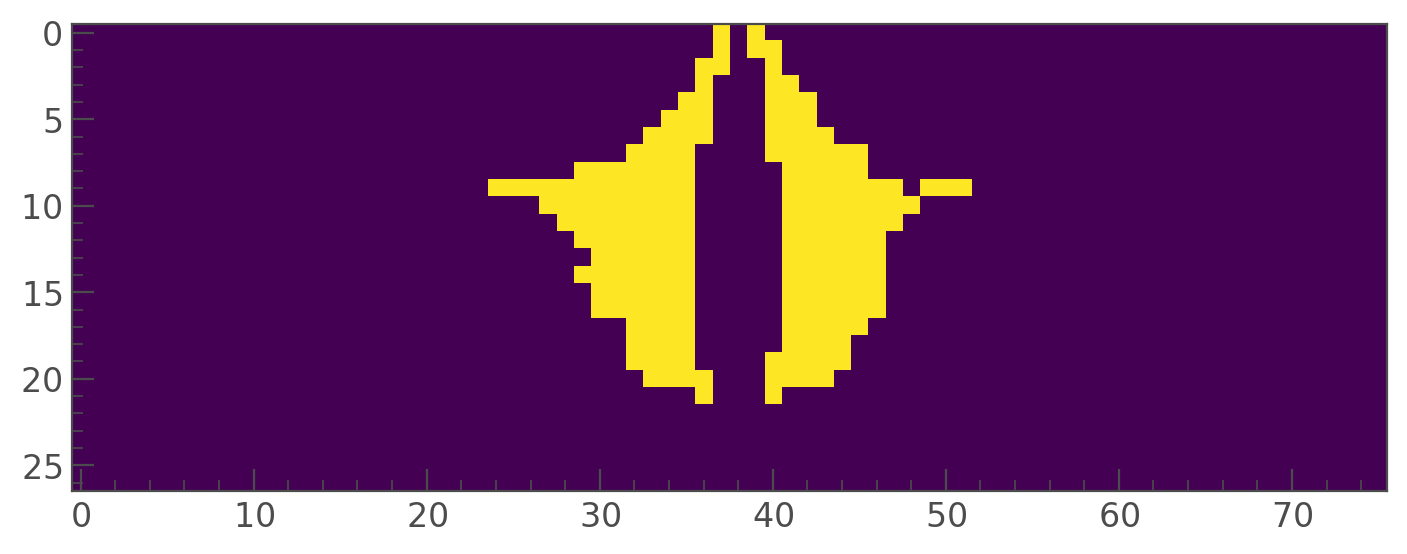

In [1001]:
plt.imshow(aper)

(0, 1.5)

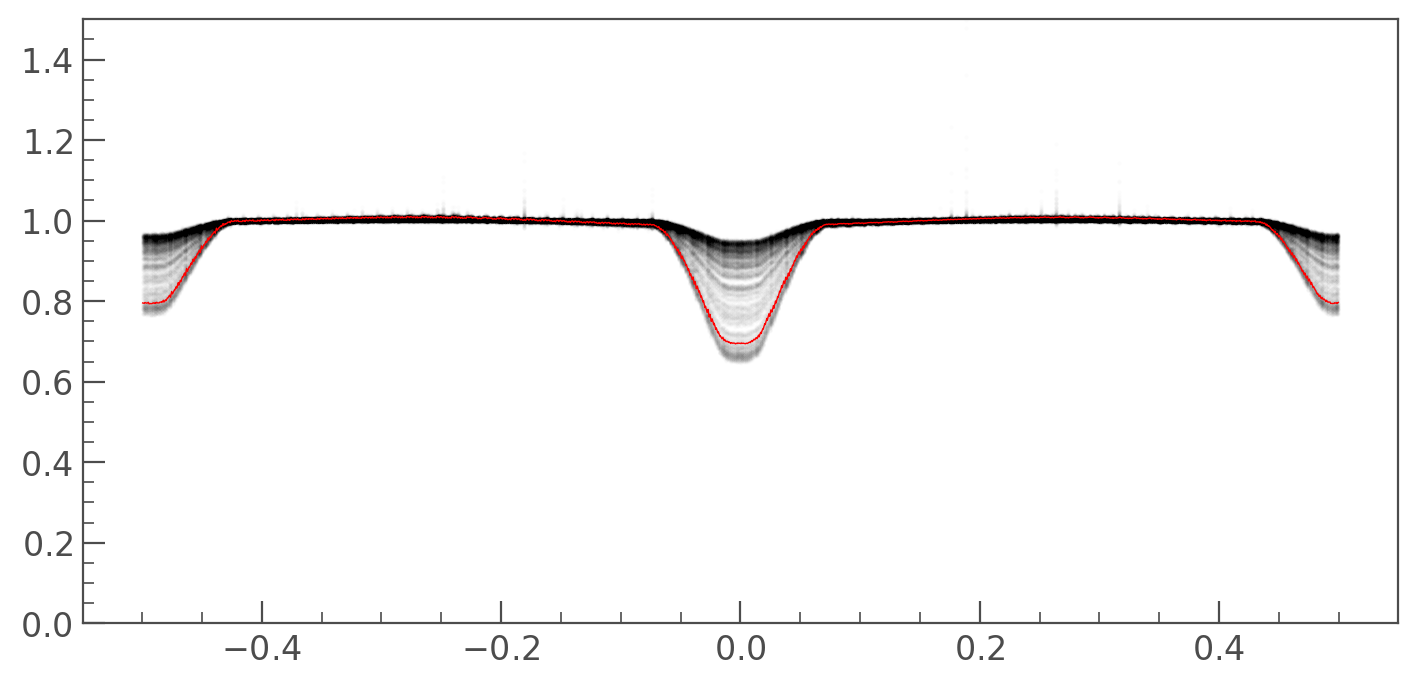

In [1002]:
plt.plot(x_fold, c_flux[:, aper], 'k.', alpha=0.01);
plt.plot(true.fold(period, t0).time, true.fold(period, t0).flux, c='r')
plt.ylim(0, 1.5)

In [1003]:
true_secondary_depth/true_primary_depth

1.1434822

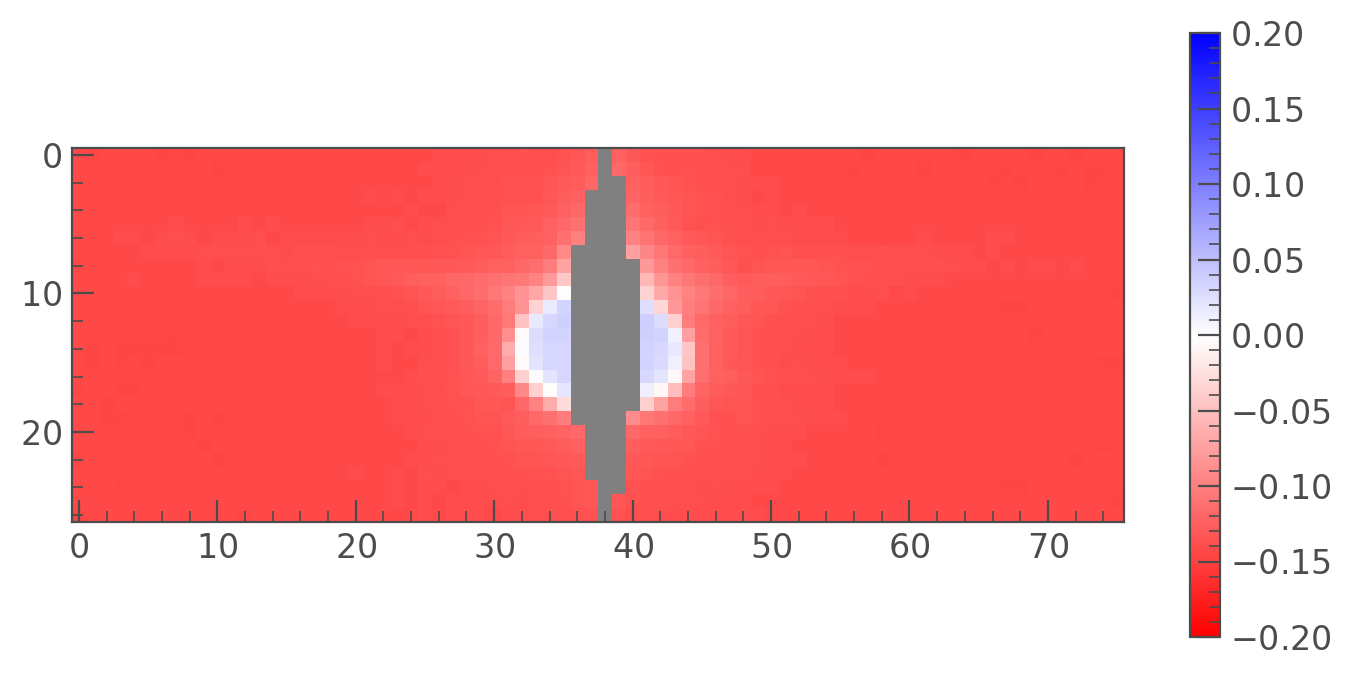

In [1004]:
plt.imshow((secondary_depth/primary_depth) - (true_secondary_depth/true_primary_depth), cmap='bwr_r', vmax=0.2, vmin=-0.2)#, vmax=1.03, vmin=1.0)
plt.colorbar()

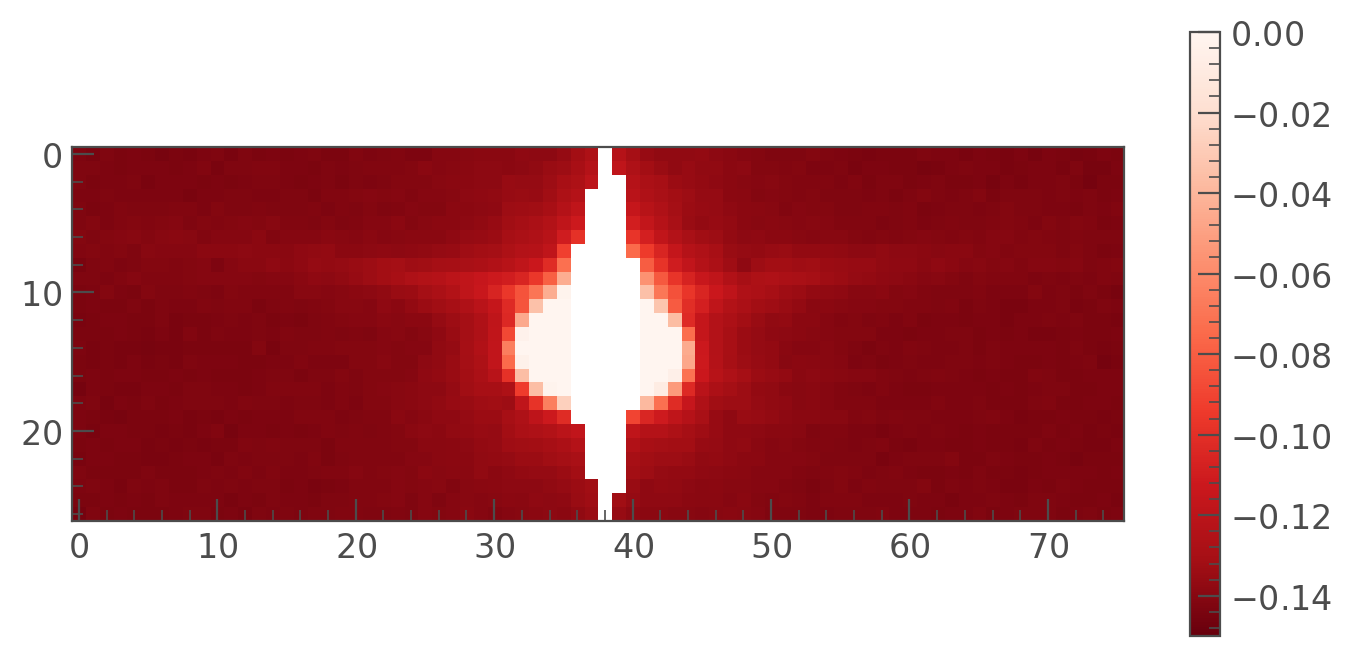

In [1005]:
plt.imshow((secondary_depth/primary_depth) - (true_secondary_depth/true_primary_depth), cmap='Reds_r', vmax=0., vmin=-0.15)#, vmax=1.03, vmin=1.0)
plt.colorbar()

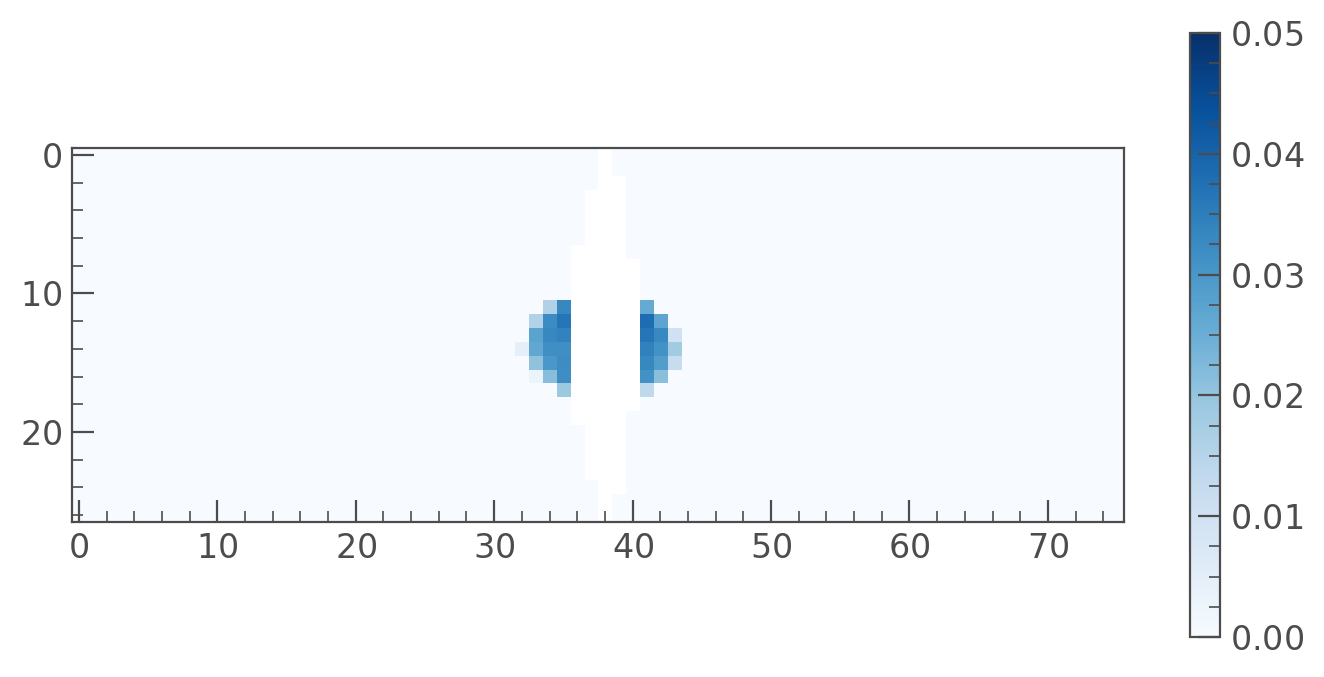

In [1006]:
plt.imshow((secondary_depth/primary_depth) - (true_secondary_depth/true_primary_depth), cmap='Blues', vmax=0.05, vmin=0)#, vmax=1.03, vmin=1.0)
plt.colorbar()

In [1007]:
#ax = plt.subplots(1)
#cmap = plt.get_cmap('bwr_r')
#cmap.set_bad('grey', 1)
#plt.imshow(secondary_depth - true_secondary_depth, vmin=-0.05, vmax=0.05, cmap=cmap)
#cbar = plt.colorbar()
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')

In [1008]:
#plt.imshow(np.log10(flux[0])/aper, vmax=3)
#plt.colorbar()

In [1009]:
norm_depth_ratio = secondary_depth[all_aper]/primary_depth[all_aper] - true_secondary_depth/true_primary_depth

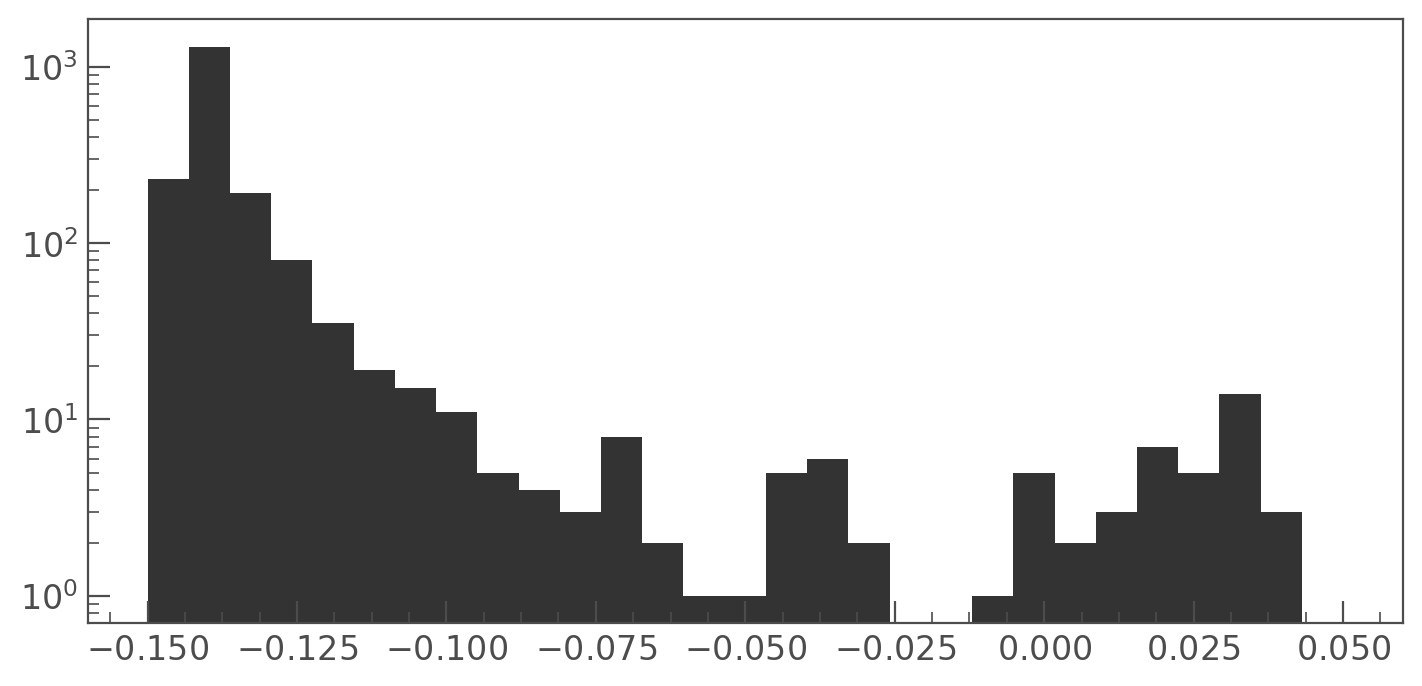

In [1010]:
plt.hist(norm_depth_ratio[np.isfinite(norm_depth_ratio)], np.linspace(-0.15, 0.05, 30));
plt.yscale('log')

In [1011]:
x_fold = (tpf.time - t0 - period/2) / period % 1 - 0.5
inds = np.array_split(np.argsort(x_fold), np.linspace(0, len(x_fold), 100, dtype=int))[1:-1]
x_fold_b = np.asarray([np.median(x_fold[ind]) for ind in inds])
c_flux_b = np.asarray([np.median(c_flux[ind, :, :], axis=0) for ind in inds])
true_flux_b = np.asarray([np.median(true.flux[ind]) for ind in inds])

In [1012]:
cmap = plt.get_cmap('RdBu')
norm = MidPointNorm(midpoint=0, vmin=-0.15, vmax=0.05)
cmap.set_bad('lightgrey', 1)

In [1013]:

# Matplot lib stuff
fig, ax = plt.subplots(figsize=(17, 8))

for l, s, p in zip(c_flux_b[:, aper].T, secondary_depth[aper], primary_depth[aper]):
    c = (s/p - true_secondary_depth/true_primary_depth)
    d = (1 - p)/(1 - true_primary_depth)
    l2 = (l * (1/d) - (1/d) + 1)
    ax.plot(x_fold_b, l2, color=cmap(norm(c)), zorder=c)

#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Pixel Light Curves')



Text(0,0.5,'Pixel Light Curves')

In [1014]:
# Matplot lib stuff
fig, ax = plt.subplots(figsize=(17, 8))

for l, s, p in zip(c_flux_b[:, aper].T, secondary_depth[aper], primary_depth[aper]):
    c = (s/p - true_secondary_depth/true_primary_depth)
    d = (1 - p)/(1 - true_primary_depth)
    l2 = (l * (1/d) - (1/d) + 1)
    ax.plot(x_fold_b, l2/true_flux_b, color=cmap(norm(c)), zorder=c)

#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Pixel Light Curves')
ax.axvline(0, ls='--', color='k')
ax.text(0, 1.02, 'PRIMARY', ha='center')



Text(0,1.02,'PRIMARY')

(0, 1)

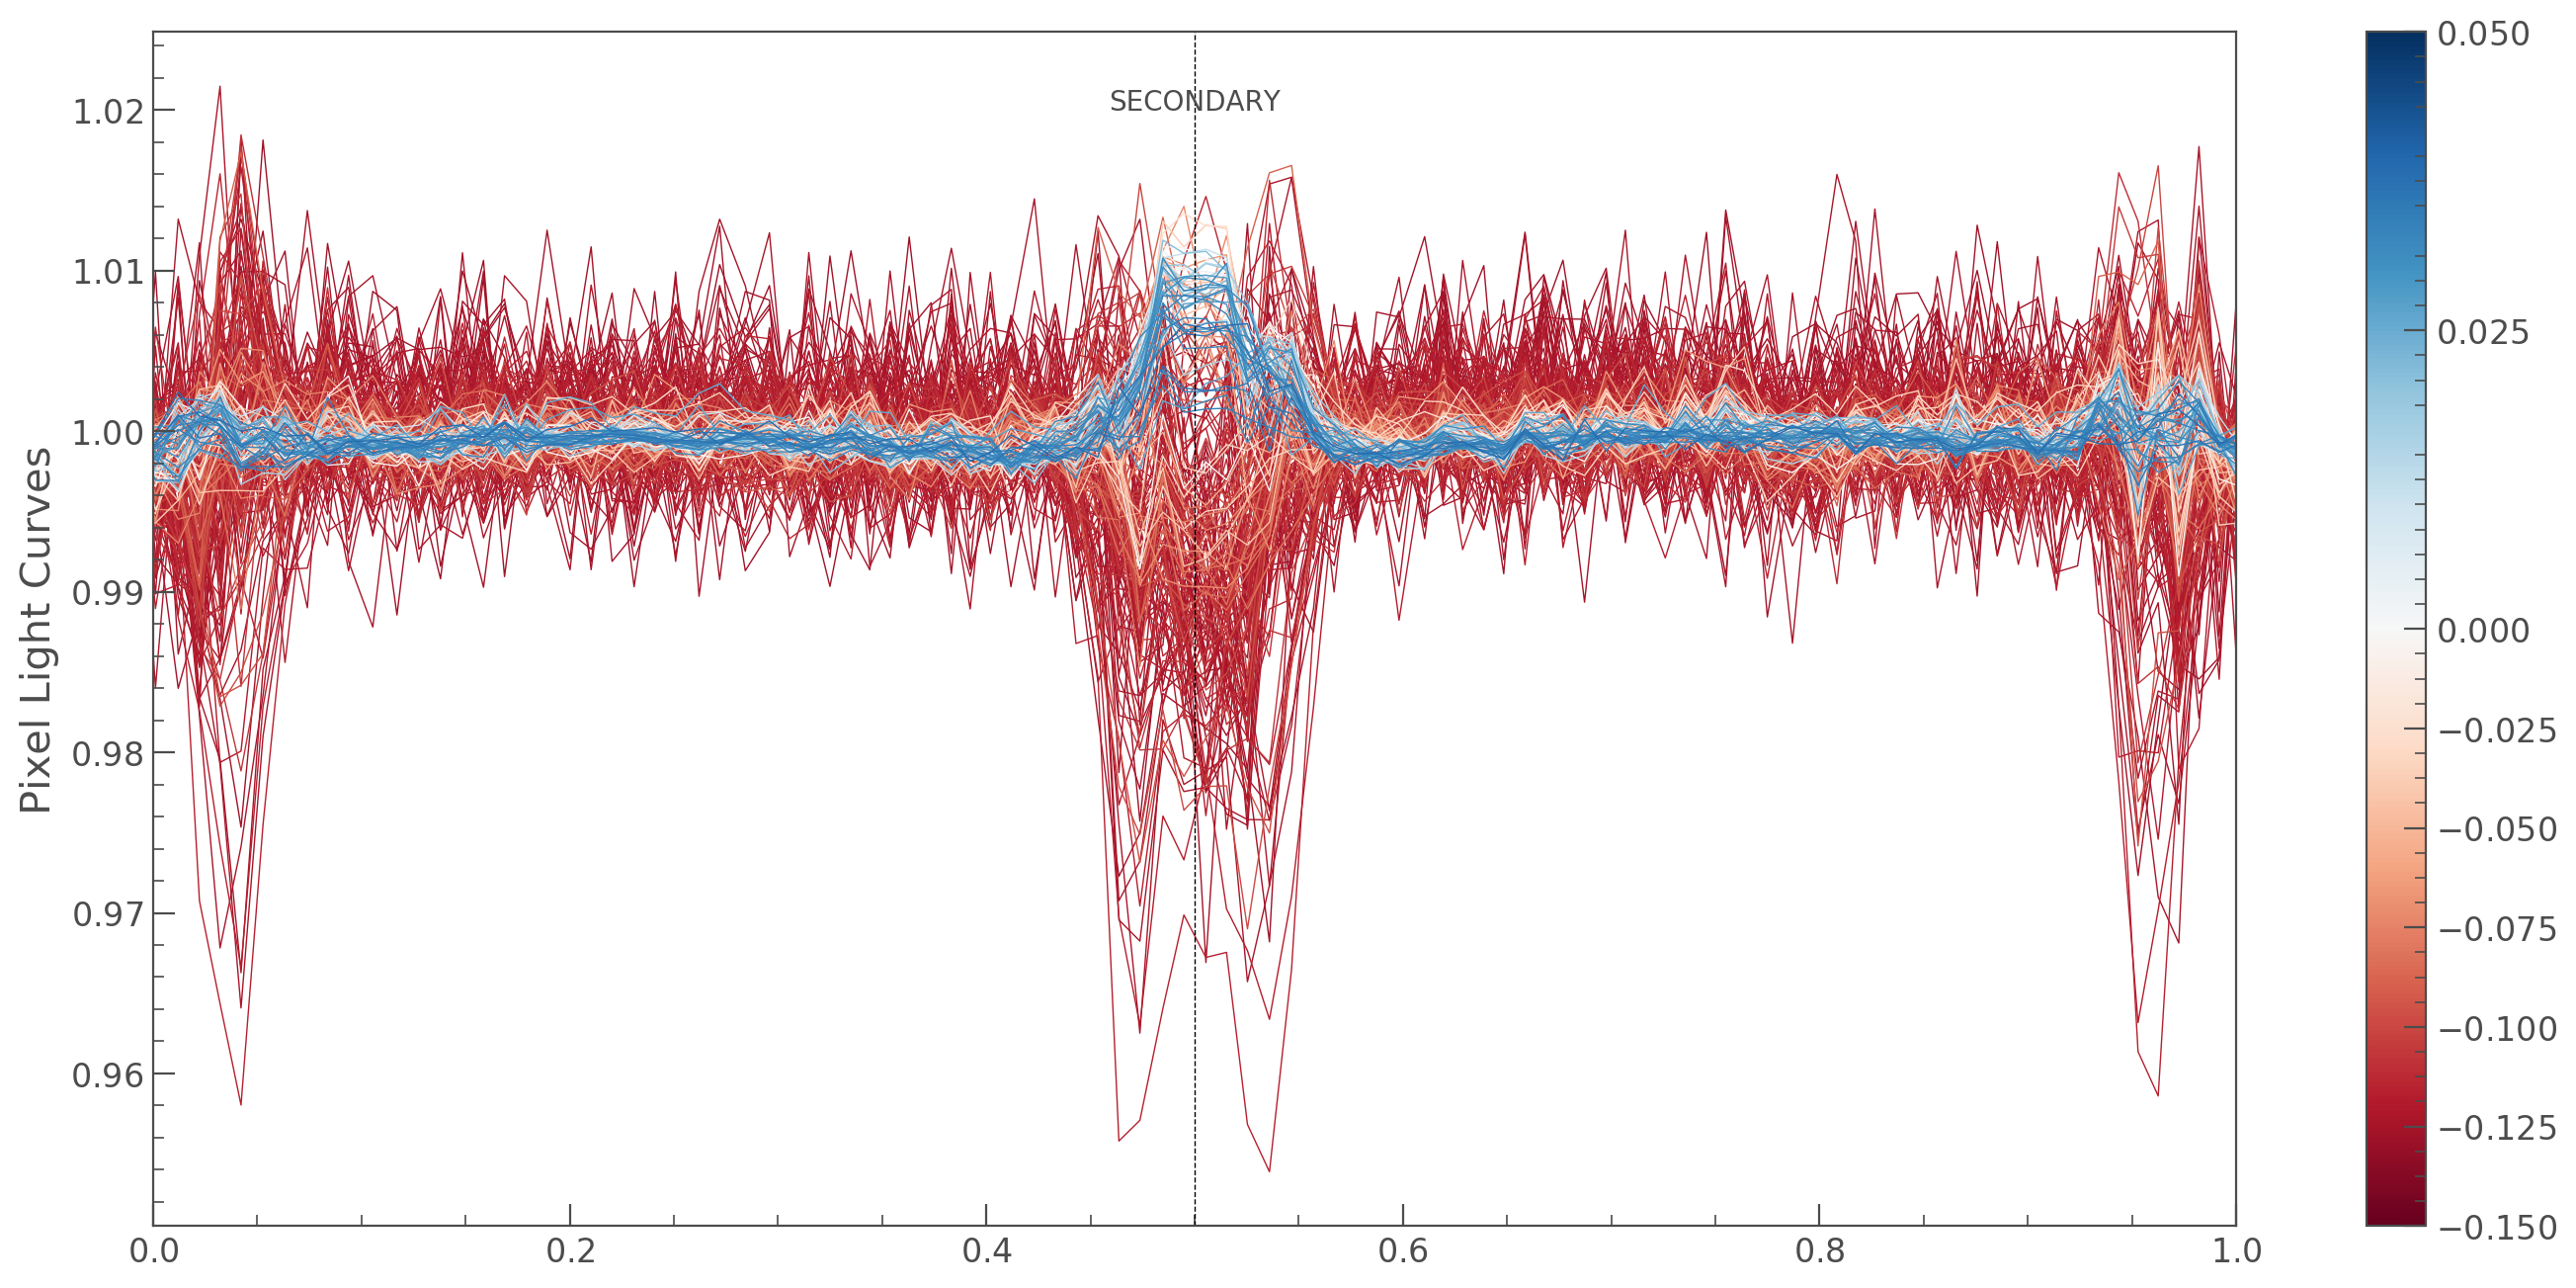

In [1015]:
# Matplot lib stuff
fig, ax = plt.subplots(figsize=(17, 8))

for l, s, p in zip(c_flux_b[:, aper].T, secondary_depth[aper], primary_depth[aper]):
    c = (s/p - true_secondary_depth/true_primary_depth)
    d = (1 - p)/(1 - true_primary_depth)
    l2 = (l * (1/d) - (1/d) + 1)
    
    x, y = np.hstack([x_fold_b, x_fold_b + 1]), np.hstack([l2/true_flux_b, l2/true_flux_b])
    ax.plot(x, y, color=cmap(norm(c)), zorder=c)
#    ax.plot(x_fold_b + 1, l2/true_flux_b, color=cmap(norm(c)), zorder=c)


#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Pixel Light Curves')
ax.axvline(0.5, ls='--', color='k')
ax.text(0.5, 1.02, 'SECONDARY', ha='center')
ax.set_xlim(0, 1)

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


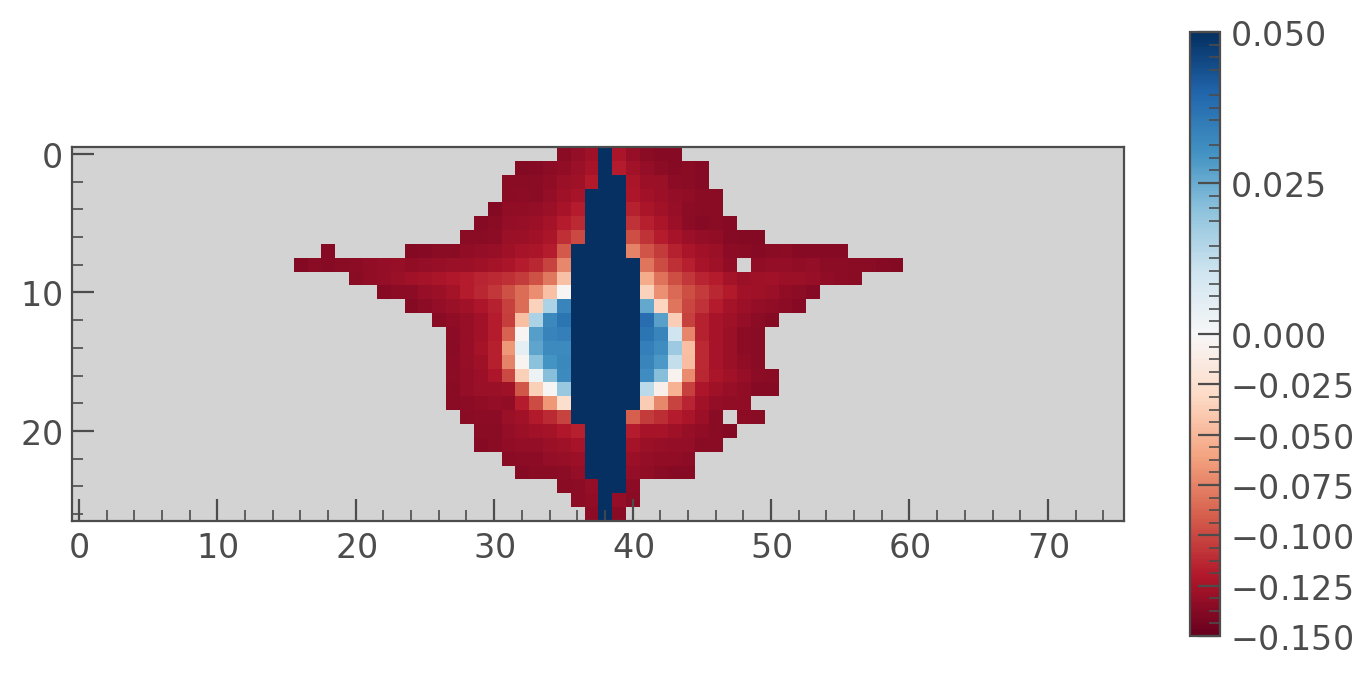

In [999]:
im = norm_depth_ratio.reshape(flux.shape[1:])
im[~aper] = np.nan
im[saturated] = 1
plt.imshow(im, norm=norm, cmap=cmap)
plt.colorbar()

In [981]:
secondary_depth/primary_depth - true_secondary_depth/true_primary_depth

array([[-0.1425855 , -0.14401091, -0.14237224, ..., -0.14367822,
        -0.14250533, -0.1433194 ],
       [-0.14219642, -0.14223451, -0.14295418, ..., -0.14452981,
        -0.1445633 , -0.14291539],
       [-0.14223085, -0.14305602, -0.14286718, ..., -0.14484615,
        -0.14317694, -0.14309937],
       ...,
       [-0.14282771, -0.14197636, -0.14288088, ..., -0.14308118,
        -0.14326986, -0.14332895],
       [-0.14354891, -0.14335744, -0.14259596, ..., -0.14311168,
        -0.14281442, -0.14397109],
       [-0.14477742, -0.14237361, -0.14302833, ..., -0.14218445,
        -0.14323395, -0.14281651]])

(0.95, 1.02)

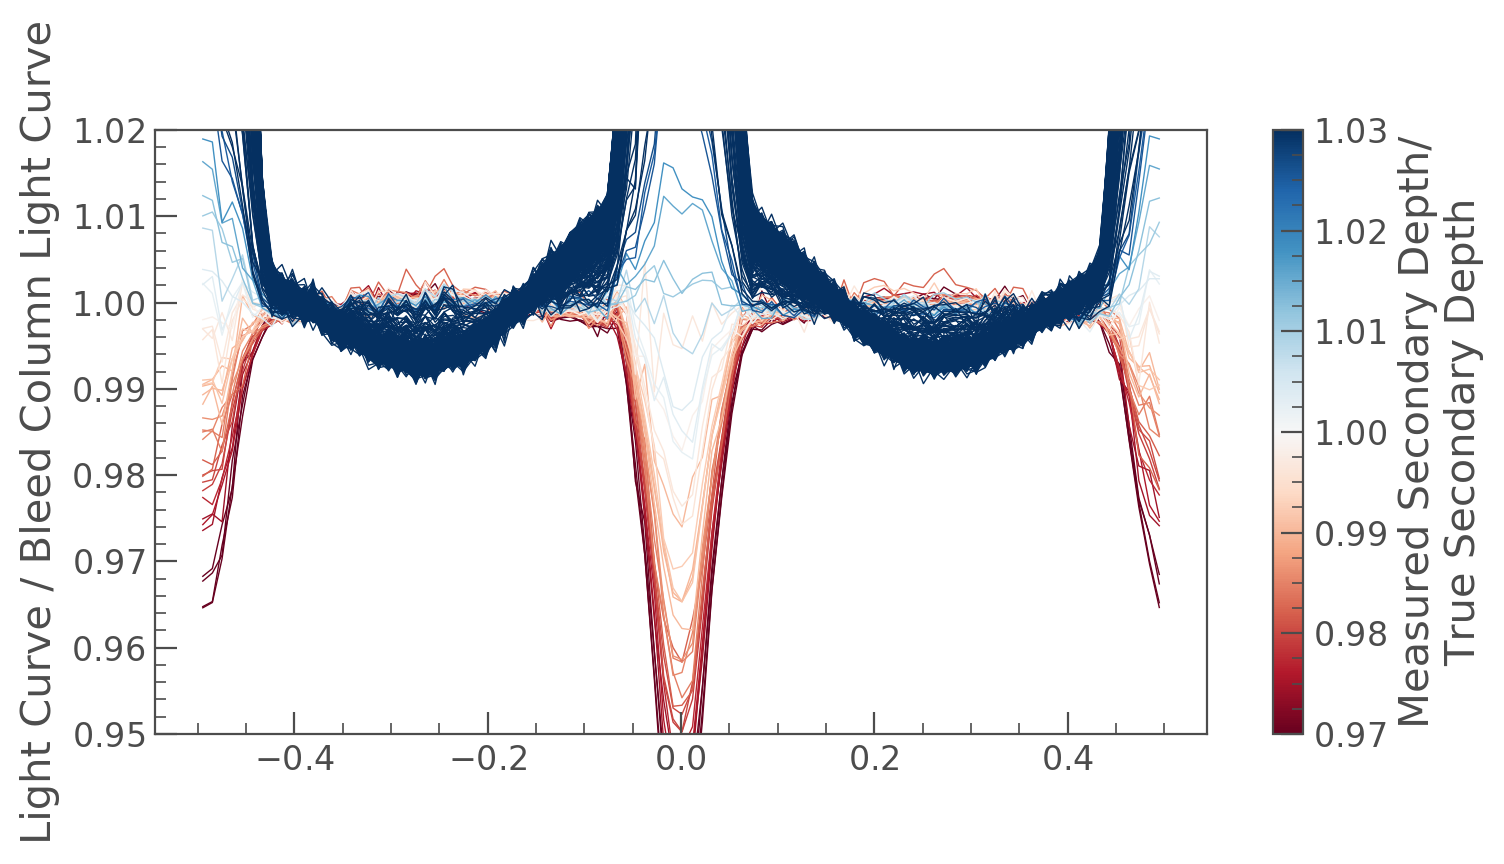

In [982]:
# Matplot lib stuff
fig, ax = plt.subplots()
norm = mpl.colors.Normalize(vmin=0.97, vmax=1.03)
cmap = plt.get_cmap('RdBu')

for l, s in zip(c_flux_b[:, aper].T, secondary_depth[aper]/true_secondary_depth):
    ax.plot(x_fold_b, l/true_flux_b, color=cmap(norm(s)), zorder=s)

#Horrible Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Measured Secondary Depth/\nTrue Secondary Depth')
ax.set_ylabel('Light Curve / Bleed Column Light Curve')

ax.set_ylim(0.95, 1.02)

In [603]:
cmap(norm(s))

(0.926874279123414, 0.5780853517877739, 0.4568242983467896, 1.0)

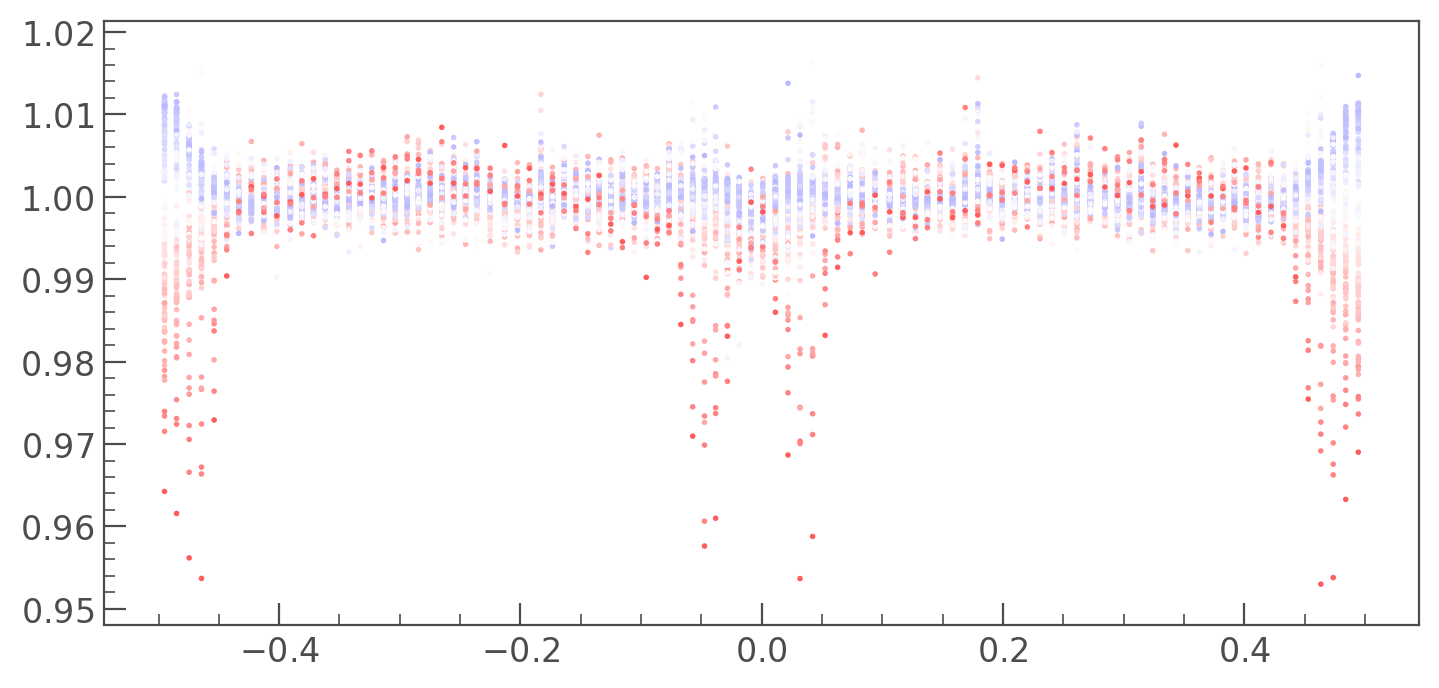

In [533]:
x = np.atleast_2d(x_fold_b).T * np.ones(aper.sum())
c = np.atleast_2d(np.ones(99)).T * (secondary_depth/true_secondary_depth)[aper]
plt.scatter(x, c_flux_b[:, aper]/np.atleast_2d(true_flux_b).T, c=c, cmap='bwr_r', vmin=0.95, vmax=1.05);

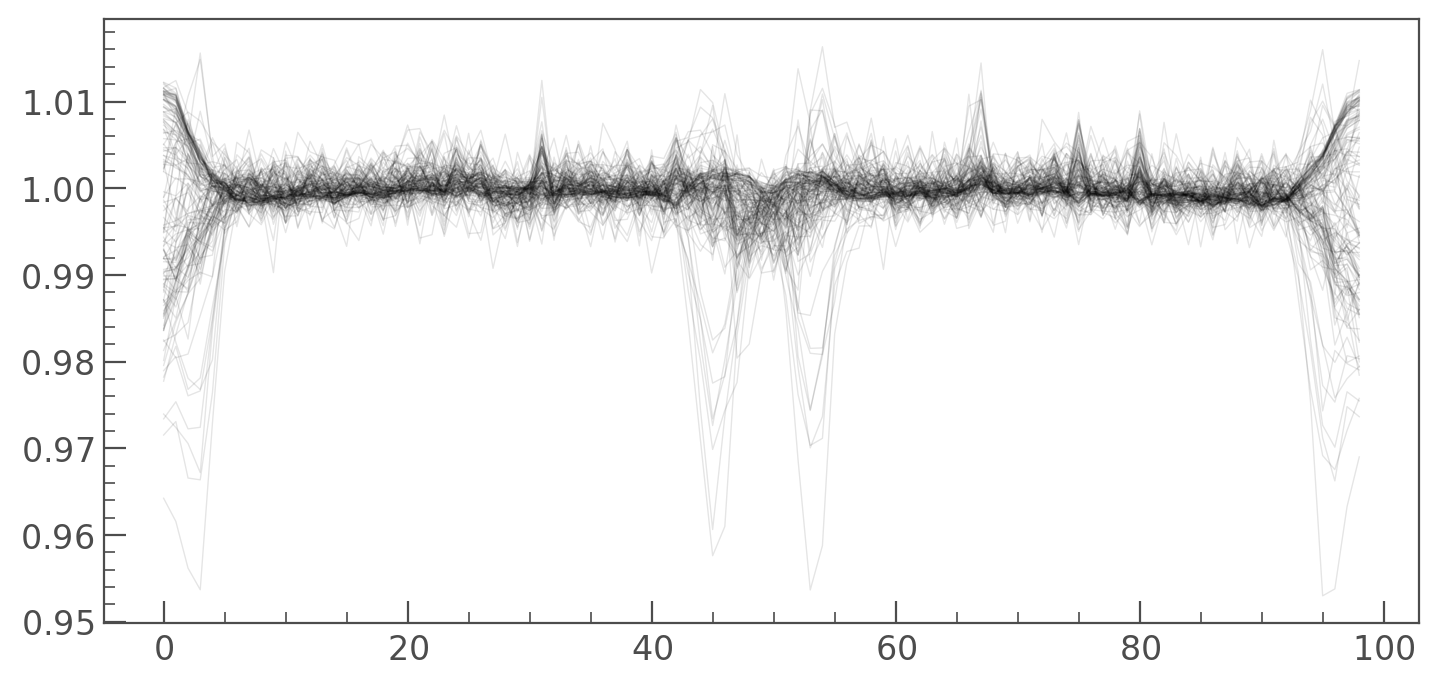

In [535]:
plt.plot(c_flux_b[:, aper]/np.atleast_2d(true_flux_b).T, c='k', alpha=0.1);